# On the Distribution Function of Order Statistics

Let $Z_{(1)} \le \ldots \le Z_{(n)}$ denote the [order statistics](https://en.wikipedia.org/wiki/Order_statistic) of a collection of independent random variables, $Z_{i}$ indexed by $i \in N$ where $|N| = n$.  Let $F_i$ and $f_i$ be the distribution and density functions for each $i$.

To generate, the order statistics we do the following:
$$
\begin{align*}
& Z_{i} \sim F_i\quad\textbf{for } i \in N \\
& Z_{(1)}, \ldots, Z_{(n)} = \mathrm{sort}\left([ Z_{i} \textbf{ for }i \in N ] \right)
\end{align*}
$$

In this post, we work out the distribution and density functions for each $Z_{(k)}$.

There is no shortage of lecture notes and books online that describe the distribution functions for $Z_{(1)}$ (min) and $Z_{(n)}$ (max) as these cases are particularly simple and more commonly used; similarly, for the case of identically distributed random variables (where the $F_i$s are equal).
The more general (non-identical, but still independent) case turns out to not be too much harder.  Why do *I* care about this problem?  These distribution functions arise when analyzing order-based sampling without replacement designs, such as the [Gumbel-top-k design](https://timvieira.github.io/blog/tag/gumbel.html) that I have written about many times.  

Before continuing, I should note that my derivation and implementation draws heavily on [Aires (1999)](https://link.springer.com/article/10.1023/A:1010091628740); specifically, Lemma 2.

Without further ado...

### Distribution function
$$
\begin{align*}
F^N_{(k)}(t)
&\overset{\mathrm{def}}{=} \mathrm{Pr}\left( Z_{(k)} \le t \right) \\
&= \mathrm{Pr}\left( \text{at least } k \text{ of } Z_1 \ldots Z_n \text{ are } \le t \right)  \\
&= \sum_{\substack{ Y \subseteq N \\ |Y| \ge k}}
  \underbrace{\left( \prod_{i \in Y} F_i(t) \right)}_{ \text{ values } \le t}
  \, \underbrace{\left( \prod_{i \in N \smallsetminus Y } \left( 1-F_i(t) \right) \right)}_{ \text{ values } > t}
\end{align*}
$$
It is a sum over all the ways in which $t$ can be the $k^{\text{th}}$ order statistics: there must be *at least* $k$ values that are $\le t$, and the remaining values that are $> t$.  These events are mutually exclusive and exhaustive.  Let $Y$ be the set of variables that are $\le t$. Clearly, we require $|Y| \ge k$.  Because the $Z_i$s are independent, the probability of the event that $Y$ is the set of $k$ smallest elements is simply the product of the $F_i$s in $Y$ and $(1-F_i)$s in the complement of $Y$.

It turns out that we can evaluate the exponential-size sum in $\mathcal{O}(n^2)$ time with a simple algorithm, which is essentially a *probabilistic generalization* of the dynamic program for evaluating the binomial coefficients, ${n \choose k}$.  Furthermore, we can simultaneously evaluate the distribution function for *all* $n$ order statistics in $\mathcal{O}(n^2)$ time.  The algorithm for doing this computation efficiently is in the code section of this article.

### Density function
\begin{align}
f^N_{(k)}(t)
&\overset{\mathrm{def}}{=} \frac{\partial}{\partial t} F^N_{(k)}(t) \\
&= \frac{\partial}{\partial t} \left[
  \sum_{\substack{ Y \subseteq N: \\ |Y| \ge k}}
  \left( \prod_{i \in Y} F_i(t) \right)
  \left( \prod_{i \in N \smallsetminus Y } \left(1-F_i(t)\right) \right)
\right] \\
&= 
\sum_j
  \sum_{\substack{ Y \subseteq N: \\ |Y| \ge k}}
  (-1)^{1[j \notin Y]} f_j(t)  
  \left( \prod_{\substack{i \in Y \\ i \ne j}} F_i(t) \right)
  \left( \prod_{\substack{i \in N \smallsetminus Y \\ i \ne j}} \left(1-F_i(t)\right) \right) \\
&= \sum_j \left(F^{N - j}_{(k-1)}(t) - F^{N - j}_{(k)}(t)\right) f_j(t)
\end{align}
where
$F^{N - j}_{(k-1)}$ and $F^{N - j}_{(k)}$ are the distribution functions for the order statistics $k-1$ and $k$ over the set of elements *excluding* the random variable $Z_j$.

## Code

In [1]:
class Ordered:
    def __init__(self, ds: 'list of distributions'):
        self.ds = ds
    def rvs(self, size=None):
        "Generate a sample of the order statistics"
        return np.sort([d.rvs(size) for d in self.ds], axis=0)
    def cdf(self, t):
        "Evaluate the CDF of the order statistics."
        p = np.array([d.cdf(t) for d in self.ds])
        return C(p, 1-p)[1:]
    def pdf(self, K, t):
        "Evaluate the PDF of the Kth order statistics."
        p = np.array([d.cdf(t) for d in self.ds])
        [_, d_p, d_q] = d_C(p, 1-p, K+1)   # off-by-one due to shift in cdf
        return sum((d_p[n] - d_q[n]) * self.ds[n].pdf(t) for n in range(len(self.ds)))

### Utility functions to efficiently sum over weighted subsets.


**Definition**: Let $p_i$ and $q_i$ be inclusion and exclusion weights (respectively) for some set of elements $i \in N$.  The total weight of subsets of $N$ of size with size least $K$ is
$$
C^N_K 
\overset{\mathrm{def}}{=} \sum_{\substack{Y \subseteq N:\\ |Y|\ge K}} \left(\prod_{i \in Y} p_i \right)\left(\prod_{i \in N \smallsetminus Y} q_i\right)
$$
We can evaluate $C^N_K$ efficiently in $\mathcal{O}(n^2)$ with the following algorithms.

In [2]:
def B(p, q):
    """
    Compute the sum of weighted sets of size == k.
    p and q are the inclusion and exclusion weights, respectively
    """
    N = len(p)
    F = np.zeros((N+1,N+1), dtype=p.dtype)
    F[:,0] = 1
    for n in range(N):
        F[n+1,0] = q[n] * F[n,0]
    for k in range(1, N+1):
        for n in range(N):
            F[n+1,k] = q[n] * F[n,k] + p[n] * F[n,k-1]
    return F[N,:]

In [3]:
def C(p, q):
    """
    Compute the sum of weighted sets of size >= k.
    p and q are the inclusion and exclusion weights, respectively
    """
    N = len(p)
    b = B(p, q)
    c = np.zeros(N+2, dtype=p.dtype)
    for j in reversed(range(N+1)):
        c[j] += c[j+1]
        c[j] += b[j]
    return c

The method below is used to efficiently evaluate the gradient of the `C` function in time $\mathcal{O}(n^2)$.  This method is used to evaluated the PDF.  It was derived by manually applying algorithmic differentiation, but it could also be evaluated using an automatic differentiation toolkit ([read more](https://timvieira.github.io/blog/post/2016/09/25/evaluating-fx-is-as-fast-as-fx/)).

In [4]:
def d_C(p, q, K):
    "Evaluate ∇[C(p)[K]]"
    N = len(p)
    assert K > 0

    F = np.zeros((N+1, N+1))
    F[:,0] = 1
    for n in range(N):
        F[n+1,0] = q[n] * F[n,0]
    for k in range(1, N+1):
        for n in range(N):
            F[n+1,k] = q[n] * F[n,k] + p[n] * F[n,k-1]

    c = np.zeros(N+2, dtype=p.dtype)
    for j in reversed(range(N+1)):
        c[j] += F[N,j]
    for j in reversed(range(N+1)):
        c[j] += c[j+1]

    out = c[K]

    d_F = np.zeros_like(F)
    d_p = np.zeros_like(p)
    d_q = np.zeros_like(q)
    d_c = np.zeros_like(c)

    d_c[K] += 1
    for j in range(N+1):
        d_c[j+1] += d_c[j]
    for j in range(N+1):
        d_F[N,j] += d_c[j]

    for k in reversed(range(1, N+1)):
        for n in reversed(range(N)):
            d_F[n,k] += q[n] * d_F[n+1,k]
            d_F[n,k-1] += p[n] * d_F[n+1,k]
            d_q[n] += F[n,k] * d_F[n+1,k]
            d_p[n] += d_F[n+1,k] * F[n,k-1]

    for n in reversed(range(N)):
        d_q[n] += d_F[n+1,0] * F[n,0]
        d_F[n,0] += q[n] * d_F[n+1,0]

    return [out, d_p, d_q]

## Tests

**Synethic Data**

Below, we test out our analytical method for computing the distribution function of independent normal distributions.  The method should work for any collection of distributions in `scipy.stats`.  You can even mix and match the distribution types.  We will compare the analytical $F_{(k)}$ to the empirical distribution of $Z_{(k)}$ using a large sample size.

In [5]:
import scipy.stats as st, numpy as np, pylab as pl
from numpy.random import uniform
np.random.seed(90210)
N = 16
m = Ordered([st.norm(uniform(-1, 1), uniform(0, 1)) for i in range(N)])

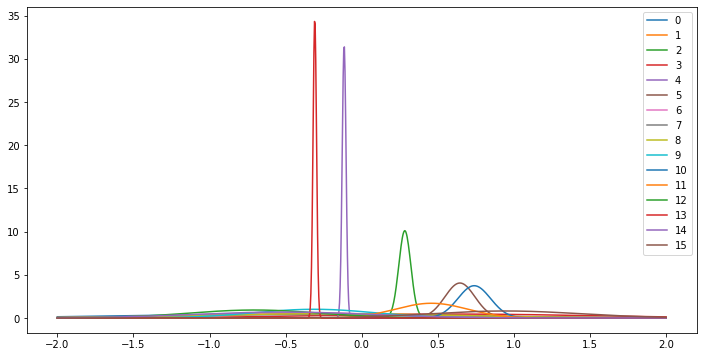

In [6]:
ts = np.linspace(-2, 2, 1000)
pl.figure(figsize=(12, 6))
for i in range(N):
    pl.plot(ts, m.ds[i].pdf(ts), label=i)
pl.legend(loc='best');

In [7]:
n_samples = 100_000
S = m.rvs(n_samples)

**CDF**

Below, I use my [arsenal library](https://github.com/timvieira/arsenal/blob/5f70cf6b1465f3eea20acec58c58c3c055c611ab/arsenal/maths/rvs.py#L280) to fit the empirical distribution function and compare it to the analytical solution.

In [8]:
from arsenal.maths import Empirical
ts = np.linspace(S.min(), S.max(), 200)
E = [Empirical(S[k]) for k in range(N)]
F = np.array([m.cdf(t) for t in ts]).T

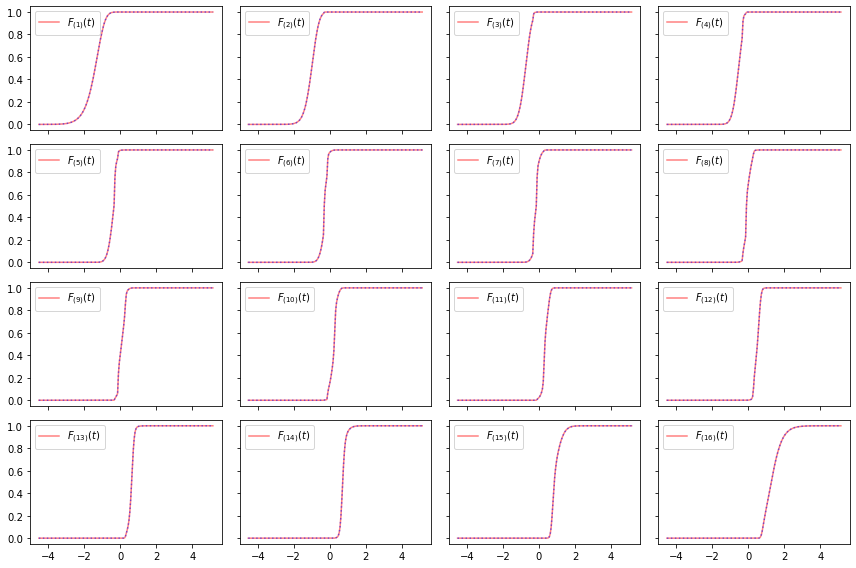

In [9]:
ncols = 4
fig, ax = pl.subplots(figsize=(12,8), nrows=int(np.ceil(N/ncols)), ncols=ncols, 
                      sharex=True, sharey=True)
ax = np.atleast_2d(ax)
for k in range(N):
    ax_ = ax[k//ncols,k%ncols]
    ax_.plot(ts, E[k].cdf(ts), c='r', alpha=0.5, 
                      label = r'$F_{(%s)}(t)$' % (k+1))
    ax_.plot(ts, F[k], c='b', alpha=0.5, linestyle=':')
    ax_.legend(loc='best')
fig.tight_layout();

In the plots above, the red line is the empirical distribution funciton, and the blue dotted line is the analytical distribution function.  In all cases, we see that the fit is good.

**PDF**

Below, we check the PDF against histograms.

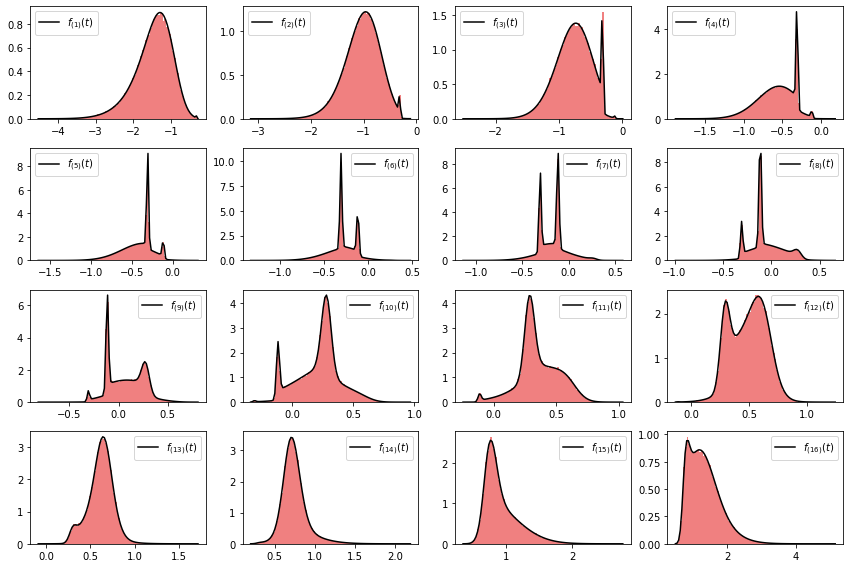

In [10]:
fig, ax = pl.subplots(figsize=(12,8), nrows=int(np.ceil(N/ncols)), ncols=ncols)
ax = np.atleast_2d(ax)
for k in range(N):
    ax_ = ax[k//ncols,k%ncols]
    ax_.hist(E[k].x, density=True, color='lightcoral', bins=100)
    ts = np.linspace(E[k].x.min(), E[k].x.max(), 100)
    ax_.plot(ts, [m.pdf(k, t) for t in ts], c='k', label=r'$f_{(%s)}(t)$' % (k+1))
    ax_.legend(loc='best')
fig.tight_layout();

## Closing 

I would like to thank Lin Zheng and the commenter "Mechanical Turk" for pointing out a mistake in the original version of this article.  I would also like to thank Ryan Cotterell for valuable feedback and discussions that greatly improved this article.

This Jupyter notebook is available for [download](https://github.com/timvieira/blog/blob/master/content/Order-Statistics.ipynb).

I am very happy to answer questions! There are many ways to do that: comment at the end of this document, Tweet at [@xtimv](https://twitter.com/xtimv), or email tim.f.vieira@gmail.com.  If you found this article interesting please consider sharing it on social media. If you found this article useful please cite it

```bibtex
@misc{vieira2021order,
  author = {Tim Vieira},
  title = {On the Distribution Function of Order Statistics},
  year = {2021},
  url = {https://timvieira.github.io/blog/post/2021/03/18/on-the-distribution-functions-of-order-statistics/}
}
```

## Appendix

**Symbolic tests for utility methods `B` and `C`**

I have included some extra material for testing the efficient algorithms for summing over subsets of size $=K$ and size $\ge K$.  This strategy compares the efficient and inefficient algorithms (brute-force enumeration) using symbolic mathematics.  Using symbolic mathematics ensures that the tests do not depend on any specific numerical values.  Furthermore, it is helpful during debugging as we can see which terms in the output expressions are different.

In [11]:
import sympy
from sympy import Symbol
from arsenal.maths.combinatorics import powerset

def C_slow(p, q):
    N = len(p)
    z = [None for _ in range(N+1)]
    for K in range(N+1):
        z[K] = 0
        for Y in powerset(range(N)):
            if len(Y) >= K:
                z[K] += sympy.prod([p[i] for i in Y]) * sympy.prod([q[i] for i in range(N) if i not in Y])
    return z


def B_slow(p, q):
    N = len(p)
    z = [0 for _ in range(N+1)]
    for Y in powerset(range(N)):
        K = len(Y)
        z[K] += sympy.prod([p[i] for i in Y]) * sympy.prod([q[i] for i in range(N) if i not in Y])
    return z


def test_symbolic():
    Xs = np.array([Symbol(x) for x in 'uvwxyz'])
    Ys = np.array([sympy.Symbol(x) for x in 'UVWXYZ'])
    
    # Binomials
    for k in range(len(Xs)):
        have = B(Xs, Ys)[k].expand()
        want = B_slow(Xs, Ys)[k].expand()
        assert have == want
    print('Binomials size = K: passed')

    # Binomials >= size K.
    for k in range(len(Xs)):
        have = C(Xs, Ys)[k].expand()
        want = C_slow(Xs, Ys)[k].expand()
        assert have == want
    print('Binomials size ≥ K: passed')

test_symbolic()

Binomials size = K: passed
Binomials size ≥ K: passed


**Inspecting the symbolic output**

Below, we look at how the expression evaluated the subsets of size $=K$ in the `B` method.  As a mnemonic, lower-case symbols represent the weight of *inclusion* into the set, and an upper-case symbols represent the weight of *exclusion* into the set.  We consider a set with $3$ elements.

In [12]:
b = B(np.array([Symbol(x) for x in 'xyz']),
      np.array([Symbol(x) for x in 'XYZ']))

In [13]:
sympy.Matrix([b]).T.expand()

Matrix([
[                X*Y*Z],
[X*Y*z + X*Z*y + Y*Z*x],
[X*y*z + Y*x*z + Z*x*y],
[                x*y*z]])

The different set sizes are the rows of the vector above.  The first row is the weight of sets of size $0$, which is $X Y Z$ because all $3$ elements are excluded.  The next line is we see that each term has one lower-case factor; this is because there is one element included in the set. See the pattern?

**Finite-difference test**

Below, we test gradients of the `C` function used in the pdf computation via the strategy described [here](https://timvieira.github.io/blog/post/2017/04/21/how-to-test-gradient-implementations/).

In [14]:
from arsenal.maths import fdcheck
def test_grad():
    N = 12
    p = np.random.uniform(0,1,size=N)
    for K in range(1, N+1):
        [_, d_p, d_q] = d_C(p, 1-p, K)
        fdcheck(lambda: C(p, 1-p)[K], p, d_p - d_q, quiet=True)
    print('fdcheck passed.')
test_grad()

fdcheck passed.


**Properties of $\nabla C$**

**Lemma**: For any $j \in N$, the following differential identities hold:
$$
\frac{\partial}{\partial p_j} C^N_K = C^{N \smallsetminus j}_{K-1}
\quad\text{and}\quad
\frac{\partial}{\partial q_j} C^N_K = C^{N \smallsetminus j}_{K}
$$

We use these identities in our derivation of the PDF.

In [15]:
def test_gradient_properties(m):
    N = len(m.ds)
    for k in range(1, len(m.ds)):
        ts = [m.rvs()[k] for _ in range(10)]
        for t in ts:
            w = m.pdf(k, t)
            ps = np.array([d.cdf(t) for d in m.ds])
            [_, d_p, d_q] = d_C(ps, 1-ps, k+1)
            h = 0.0
            for j in range(N):
                ds = list(m.ds); ds.pop(j)
                F = Ordered(ds).cdf(t)
                # we use this identity in fast method to evaluate the pdf.
                h += (F[k-1] - F[k]) * m.ds[j].pdf(t) 
                assert np.allclose(F[k-1] - F[k], d_p[j] - d_q[j])
                assert np.allclose(F[k-1], d_p[j])
                assert np.allclose(F[k], d_q[j])
            assert np.allclose(h, w)
    print('gradient_properties: pass.')
        
test_gradient_properties(m)

gradient_properties: pass.
